In [1]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import t
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV #split the data into training and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


In [2]:
training_set_complete = pd.read_csv("data/training_set_online_shoppers_intention.csv")
missing_values = training_set_complete[training_set_complete['ExitRates'].isna()]
training_set = training_set_complete[training_set_complete['ExitRates'].isna()==False]

In [3]:
X = training_set.drop(columns=['ExitRates','Revenue','Unnamed: 0'])
y = training_set['ExitRates']
X = pd.get_dummies(X, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType'], drop_first=True)
X['Weekend'] = np.where(training_set['Weekend']=='True',1,0)

## Linear and polynomial regression

In [4]:
test_size = 0.3
seed = 40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mse_train = mean_squared_error(y_train, regressor.predict(X_train))
r2_train = r2_score(y_train, regressor.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_train)
print("R-squared:", r2_train)
print("Mean Squared Error:", mse_test)
print("R-squared:", r2_test)

LinearRegression()

Mean Squared Error: 0.0002997774220603436
R-squared: 0.8722813637103644
Mean Squared Error: 0.00036221114816632375
R-squared: 0.8393430875428785


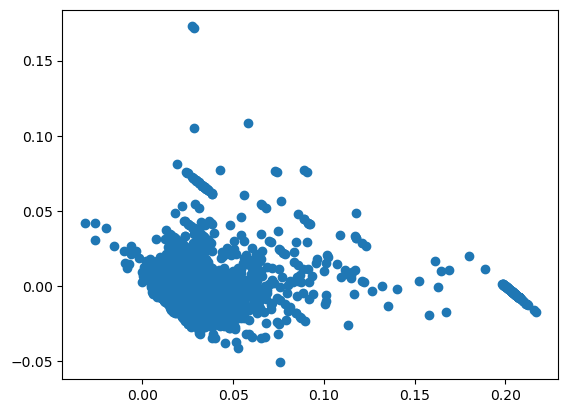

In [5]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()

Now we check if we may have a better model with polynomial features:

In [6]:
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,3))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train, y_train)
best_polynomial_model = cv.best_estimator_
print("Best Hyperparameters:", cv.best_params_)
print("Best R-squared Score:", cv.best_score_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2]},
             scoring=make_scorer(r2_score))

Best Hyperparameters: {'poly__degree': 1}
Best R-squared Score: 0.8686492903822639


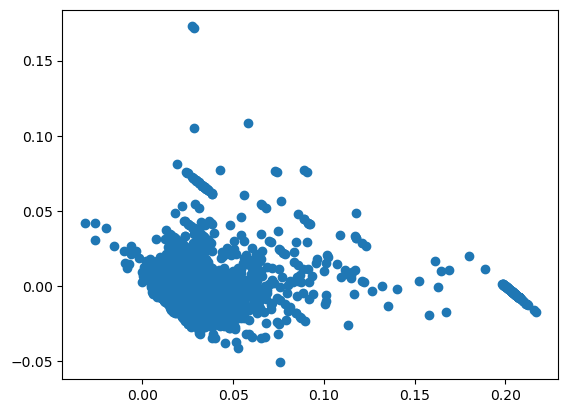

In [7]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()

## Ridge regression
We saw that the best degree is one. We want to see if we can improve it with ridge regression:

In [8]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
best_degree = 2
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('ridge', Ridge())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ridge__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['ridge'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 10.0
Best coefficients: [-0.00589608  0.00043399 -0.00159411 ...  0.00059944  0.
  0.00195718]


In [9]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model.named_steps['ridge'].coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best alpha: 10.0
Best coefficients: [-0.00589608  0.00043399 -0.00159411 ...  0.00059944  0.
  0.00195718]
Mean Squared Error: 0.0007782729968878633
R-squared: 0.6548009707549358


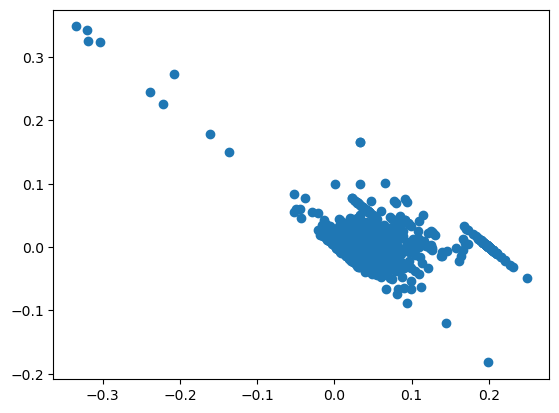

In [10]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()

The $R^2$ decreased wrt the linear model.

## Lasso

In [11]:
from sklearn.linear_model import Lasso
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
best_degree = 2
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('lasso', Lasso())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['lasso__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['lasso'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 0.01
Best coefficients: [-0. -0. -0. ...  0.  0.  0.]


In [12]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model.named_steps['lasso'].coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best alpha: 0.01
Best coefficients: [-0. -0. -0. ...  0.  0.  0.]
Mean Squared Error: 0.0005058026353833739
R-squared: 0.7756538137361416


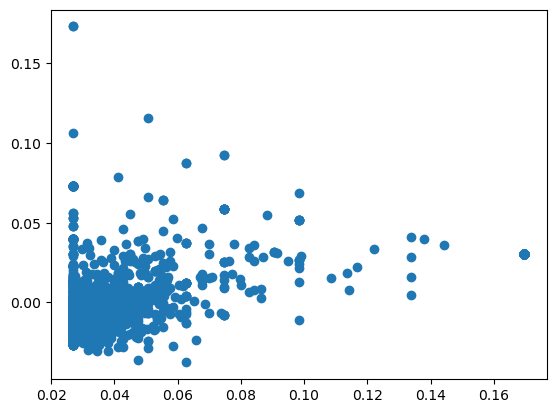

In [13]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()

## Forward stepwise selection

In [14]:
# Convert back from numpy arrays to data frames
X_all_features = list(np.delete(X.columns.values, [np.where(training_set.columns.values=='Unnamed: 0'),np.where(training_set.columns.values=='ExitRates'),np.where(training_set.columns.values=='Revenue')], axis=None))
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

In [15]:
def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator  

from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M0) with 1 features: ['BounceRates']
M0 subset score (3.): 0.8399691408563429
............
Best model (M1) with 2 features: ['BounceRates', 'ProductRelated']
M1 subset score (3.): 0.8516275104047759
............
Best model (M2) with 3 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor']
M2 subset score (3.): 0.8571340856888824
............
Best model (M3) with 4 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues']
M3 subset score (3.): 0.8603972987216352
............
Best model (M4) with 5 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration']
M4 subset score (3.): 0.862132602835359
............
Best model (M5) with 6 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2']
M5 subset score (3.): 0.8632846087167024
............
Best model (M6) with 7 features: ['

............
Best model (M25) with 26 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'VisitorType_Other', 'OperatingSystems_8', 'Month_June', 'OperatingSystems_3', 'TrafficType_10', 'TrafficType_12', 'Browser_3', 'Region_9', 'Region_3', 'Month_Oct', 'Month_Mar', 'TrafficType_16', 'Browser_7', 'TrafficType_13', 'Informational', 'TrafficType_19', 'OperatingSystems_4', 'TrafficType_14']
M25 subset score (3.): 0.8663201029410116
............
Best model (M26) with 27 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'VisitorType_Other', 'OperatingSystems_8', 'Month_June', 'OperatingSystems_3', 'TrafficType_10', 'TrafficType_12', 'Browser_3', 'Region_9', 'Region_3', 'Month_Oct', 'Month_Mar', 'TrafficType_16', 'Browser_7', 'TrafficType_13', 'Info

............
Best model (M39) with 40 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'VisitorType_Other', 'OperatingSystems_8', 'Month_June', 'OperatingSystems_3', 'TrafficType_10', 'TrafficType_12', 'Browser_3', 'Region_9', 'Region_3', 'Month_Oct', 'Month_Mar', 'TrafficType_16', 'Browser_7', 'TrafficType_13', 'Informational', 'TrafficType_19', 'OperatingSystems_4', 'TrafficType_14', 'Browser_12', 'Browser_13', 'ProductRelated_Duration', 'TrafficType_18', 'TrafficType_3', 'Month_Dec', 'Month_May', 'Month_Feb', 'Region_6', 'OperatingSystems_6', 'Month_Nov', 'Month_Jul', 'TrafficType_7', 'Browser_6']
M39 subset score (3.): 0.8662418398783502
............
Best model (M40) with 41 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'VisitorType_

............
Best model (M49) with 50 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'VisitorType_Other', 'OperatingSystems_8', 'Month_June', 'OperatingSystems_3', 'TrafficType_10', 'TrafficType_12', 'Browser_3', 'Region_9', 'Region_3', 'Month_Oct', 'Month_Mar', 'TrafficType_16', 'Browser_7', 'TrafficType_13', 'Informational', 'TrafficType_19', 'OperatingSystems_4', 'TrafficType_14', 'Browser_12', 'Browser_13', 'ProductRelated_Duration', 'TrafficType_18', 'TrafficType_3', 'Month_Dec', 'Month_May', 'Month_Feb', 'Region_6', 'OperatingSystems_6', 'Month_Nov', 'Month_Jul', 'TrafficType_7', 'Browser_6', 'Browser_10', 'Browser_4', 'TrafficType_15', 'TrafficType_8', 'Region_4', 'Region_2', 'Region_7', 'TrafficType_5', 'TrafficType_20', 'Browser_5']
M49 subset score (3.): 0.8657669286965911
............
Best model (M50) with 51 features: ['BounceRates', 'ProductRelated

............
Best model (M59) with 60 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'VisitorType_Other', 'OperatingSystems_8', 'Month_June', 'OperatingSystems_3', 'TrafficType_10', 'TrafficType_12', 'Browser_3', 'Region_9', 'Region_3', 'Month_Oct', 'Month_Mar', 'TrafficType_16', 'Browser_7', 'TrafficType_13', 'Informational', 'TrafficType_19', 'OperatingSystems_4', 'TrafficType_14', 'Browser_12', 'Browser_13', 'ProductRelated_Duration', 'TrafficType_18', 'TrafficType_3', 'Month_Dec', 'Month_May', 'Month_Feb', 'Region_6', 'OperatingSystems_6', 'Month_Nov', 'Month_Jul', 'TrafficType_7', 'Browser_6', 'Browser_10', 'Browser_4', 'TrafficType_15', 'TrafficType_8', 'Region_4', 'Region_2', 'Region_7', 'TrafficType_5', 'TrafficType_20', 'Browser_5', 'Browser_2', 'Browser_11', 'Informational_Duration', 'OperatingSystems_7', 'Region_5', 'TrafficType_6', 'Region_8', 'Traf

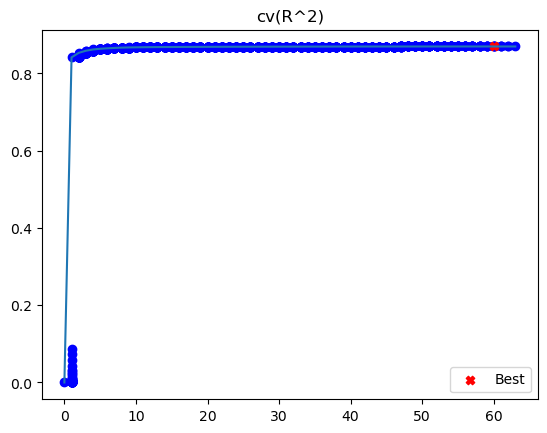

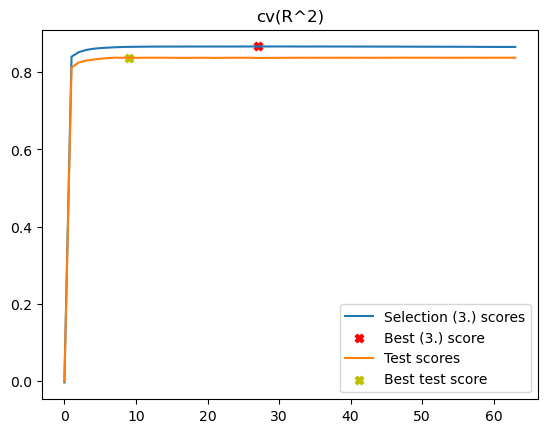

In [16]:
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=90)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator


cv = 10
sigma = estimate_sigma(X_train_pd, y_train)
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to 
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score), cv=cv), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

In [17]:
best_features = ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'VisitorType_Other', 'OperatingSystems_8', 'Month_June', 'OperatingSystems_3', 'TrafficType_10', 'TrafficType_12', 'Browser_3', 'Region_9', 'Region_3', 'Month_Oct', 'Month_Mar', 'TrafficType_16',
                 'Browser_7', 'TrafficType_13', 'Informational', 'TrafficType_19', 'OperatingSystems_4', 'TrafficType_14', 'Browser_12']
X = X[best_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [18]:
from sklearn.linear_model import Lasso
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
best_degree = 2
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('lasso', Lasso())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['lasso__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['lasso'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 0.01
Best coefficients: [ 0.03444171 -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.
 -0.          0.          0.          0.          0.         -0.
  0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.  

In [19]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model.named_steps['lasso'].coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best alpha: 0.01
Best coefficients: [ 0.03444171 -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.
 -0.          0.          0.          0.          0.         -0.
  0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.  

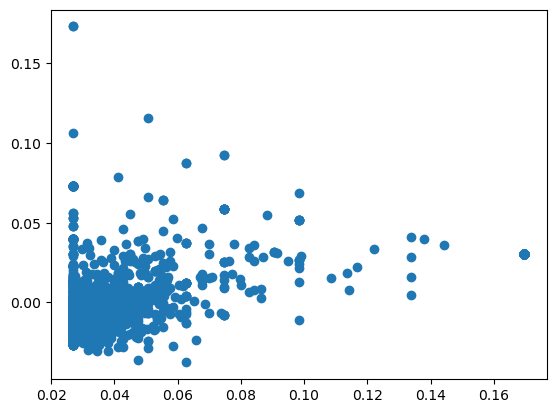

In [20]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()